In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import print_function
%matplotlib inline
import cv2
import os
from skimage import io, transform
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
import torchvision
from torchvision import transforms, datasets, utils as vutils
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
# https://www.researchgate.net/publication/353370951_Towards_Lifespan_Automation_for_Caenorhabditis_elegans_Based_on_Deep_Learning_Analysing_Convolutional_and_Recurrent_Neural_Networks_for_Dead_or_Live_Classification

from utils.data_utils import LstmLoader
from model import Resnet18Pretrained
from model import ResnetLSTM


data_path = "data/training_real"

data_loader = LstmLoader(data_path)


# Settings

learning_rate = 0.1

epochs = 100


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [4]:
sample = torch.randn(3, 3, 244, 244).to(device)

# Pass a few data to see how it looks
model = ResnetLSTM().to(device)
a = model(sample)
print(a)

sample, label = data_loader[0][0].to(device), data_loader[0][1]
out = model(sample)
print(out)

print(label)

tensor([[0.5042]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([[0.5038]], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(1)


In [5]:

test_len = int(len(data_loader) * 0.15)
train_len = len(data_loader) - test_len

print(f"Total Data: {len(data_loader)}")
print(f"Test split: {test_len}")
print(f"Train split: {train_len}")

test_data, train_data = torch.utils.data.random_split(data_loader, (test_len, train_len))

# train_data = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
# test_data = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0)


Total Data: 2245
Test split: 336
Train split: 1909


In [6]:
# train_data = DataLoader(train_data, batch_size=None, shuffle=True, num_workers=0)
# test_data = DataLoader(test_data, batch_size=None, shuffle=True, num_workers=0)

In [7]:
alive = 0
dead = 0

for i in train_data:
    seq, label = i
    if int(label) == 1:
        alive += 1
    elif int(label) == 0:
        dead += 1
        
print(dead, alive)

380 1529


In [7]:
def test_model(model2, data):
    correct = 0
    incorrect = 0
    dead_correct = 0
    dead_incorrect = 0
    alive_correct = 0
    alive_incorrect = 0
    
    with torch.no_grad():
        for series, label in data:
            series = series.to(device)
            real_class = int(label)
#             real_class = int(torch.argmax(label))
            
            output = model2(series)
            if output > 0.5:
                pred_class = 1
            elif output < 0.5:
                pred_class = 0

#             print(output, pred_class, real_class)
            if pred_class == real_class:
                correct += 1
                if pred_class == 0:
                    dead_correct += 1
                elif pred_class == 1:
                    alive_correct += 1
                    
            else:
                incorrect += 1
                if pred_class == 0:
                    dead_incorrect += 1
                elif pred_class == 1:
                    alive_incorrect += 1
    
    print(alive_correct, alive_incorrect)
    
    overall_accuracy = correct / len(data)
    alive_accuracy = alive_correct / (alive_correct + alive_incorrect) if alive_correct else 0
    dead_accuracy = dead_correct / (dead_correct + dead_incorrect) if dead_correct else 0
    
#     return (correct, incorrect, len(data))
    return round(overall_accuracy, 4), round(alive_accuracy, 4), round(dead_accuracy, 4)

test_model(model, test_data)

367 142


(0.721, 0.721, 0)

In [ ]:
# Setup Learning Params

criterion = nn.BCELoss()

# optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999))


# Training Loop
dead = 0
alive = 0

# Class:
#  0: Dead
#  1: Alive

loss_totals = []
test_totals = []
        
for epoch in range(epochs):
    loss_total = 0
    for series, label in train_data:
        model.zero_grad()
        
        series = series.to(device)
        label = label.to(device)
#         label = label.view(1,2)
        
        output = model(series).squeeze()
#         print(output, label)
        loss = criterion(output, label.float())
        loss_total += loss
#         print(output, label, loss)
        loss.backward()
        optimizer.step()
        
    
    
    test_accuracy, a_accuracy, d_accuracy = test_model(model, test_data)
    
    print(f"Epoch {epoch}/{epochs} - Test Accuracy: {test_accuracy} - A&D: {a_accuracy}, {d_accuracy} - Loss: {loss_total/len(train_data)}")
    
    loss_totals.append(loss_total/len(train_data))
    test_totals.append(test_accuracy)
    
    # Save weights
    torch.save(model.state_dict(), f"weights/run0/weights{epoch}.pt")
    print("weights saved")
    
        
        

340 3
Epoch 0/100 - Test Accuracy: 0.9411 - A&D: 0.9913, 0.8373 - Loss: 0.28729525208473206
weights saved
346 8
Epoch 1/100 - Test Accuracy: 0.943 - A&D: 0.9774, 0.8645 - Loss: 0.19463606178760529
weights saved
352 5
Epoch 2/100 - Test Accuracy: 0.9607 - A&D: 0.986, 0.9013 - Loss: 0.18164485692977905
weights saved
347 2
Epoch 3/100 - Test Accuracy: 0.9568 - A&D: 0.9943, 0.875 - Loss: 0.10192810744047165
weights saved
351 1
Epoch 4/100 - Test Accuracy: 0.9666 - A&D: 0.9972, 0.8981 - Loss: 0.08653078228235245
weights saved
349 2
Epoch 5/100 - Test Accuracy: 0.9607 - A&D: 0.9943, 0.8861 - Loss: 0.08765137195587158
weights saved
359 3
Epoch 6/100 - Test Accuracy: 0.9784 - A&D: 0.9917, 0.9456 - Loss: 0.07022090256214142
weights saved
359 2
Epoch 7/100 - Test Accuracy: 0.9804 - A&D: 0.9945, 0.9459 - Loss: 0.063375324010849
weights saved
360 3
Epoch 8/100 - Test Accuracy: 0.9804 - A&D: 0.9917, 0.9521 - Loss: 0.05680713802576065
weights saved
361 2
Epoch 9/100 - Test Accuracy: 0.9843 - A&D: 0.

In [7]:
# Save Weights
# torch.save(model.state_dict(), "weights/weights1.pt"); print("weights saved")

model = ResnetLSTM().to(device)
model.load_state_dict(torch.load("weights/run0/weights12.pt", map_location=device))

# netG = Generator(ngpu).to(device)
# netG.load_state_dict(torch.load("weights/small_generator.pt"))

# model.eval()

<All keys matched successfully>

In [10]:
validation_path = "data/validation"
validation_data = LstmLoader(validation_path)

validation_accuracy = test_model(model, validation_data)

286 1


In [11]:
print(f"Overall Validation Accuracy: {validation_accuracy[0]}, Alive Accuracy: {validation_accuracy[1]}, Dead Acuracy: {validation_accuracy[2]}")

Overall Validation Accuracy: 0.975, Alive Accuracy: 0.9965, Dead Acuracy: 0.9551


Real Label, Predicted Label:
Alive, dead


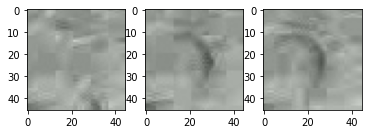

In [39]:
def show_sample(data, index, model=model):
    series, label = data[index]
    label = int(label)
    
    if label == 1:
        real = "Alive"
    elif label == 0:
        real = "Dead"
    
    raw_series, _ = data.__getitem__(index, raw=True)
    
    pred_label = model(series.to(device))
    if pred_label > 0.5:
        pred = "Alive"
    elif pred_label < 0.5:
        pred = "dead"
        
    return raw_series, real, pred
    

# model(validation_data[0][0].to(device))

f, axarr = plt.subplots(1,3)

sample_series, real, pred = show_sample(validation_data, 3)
axarr[0].imshow(sample_series[0])
axarr[1].imshow(sample_series[1])
axarr[2].imshow(sample_series[2])
# print(f"Pred: {}")
print(f"Real Label, Predicted Label:")
print(f"{real}, {pred}")

In [40]:
alive = 0
dead = 0

for i in validation_data:
    seq, label = i
    if int(label) == 1:
        alive += 1
    elif int(label) == 0:
        dead += 1
        
print(dead, alive)

299 300


In [41]:
incorrect = []
for i, item in enumerate(validation_data):
    series, label = item 
    pred_label = model(series.to(device))
    
    if label == 1:
        real = "Alive"
    elif label == 0:
        real = "Dead"
    
    if pred_label > 0.5:
        pred = "Alive"
    elif pred_label < 0.5:
        pred = "Dead"
        
    if pred == real:
        pass
    else:
        incorrect.append(i)
    
    

In [37]:
incorrect

[0, 3, 11, 34, 56, 68, 71, 150, 169, 198, 233, 279, 283, 288, 498]

In [12]:
validation_path = "test_data/fake2"
validation_data = LstmLoader(validation_path)

validation_accuracy = test_model(model, validation_data)
print(f"Overall Validation Accuracy: {validation_accuracy[0]}, Alive Accuracy: {validation_accuracy[1]}, Dead Acuracy: {validation_accuracy[2]}")

1253 73
Overall Validation Accuracy: 0.795, Alive Accuracy: 0.9449, Dead Acuracy: 0.7206


In [43]:
len(validation_data)

51

(tensor([[[[0.0035, 0.0035, 0.0035,  ..., 0.0034, 0.0034, 0.0034],
           [0.0035, 0.0035, 0.0035,  ..., 0.0034, 0.0034, 0.0034],
           [0.0035, 0.0035, 0.0035,  ..., 0.0035, 0.0035, 0.0035],
           ...,
           [0.0034, 0.0034, 0.0034,  ..., 0.0026, 0.0025, 0.0025],
           [0.0033, 0.0033, 0.0034,  ..., 0.0025, 0.0024, 0.0024],
           [0.0033, 0.0033, 0.0034,  ..., 0.0025, 0.0024, 0.0024]],
 
          [[0.0035, 0.0035, 0.0035,  ..., 0.0034, 0.0034, 0.0034],
           [0.0035, 0.0035, 0.0035,  ..., 0.0034, 0.0034, 0.0034],
           [0.0035, 0.0035, 0.0035,  ..., 0.0035, 0.0035, 0.0035],
           ...,
           [0.0034, 0.0034, 0.0034,  ..., 0.0026, 0.0025, 0.0025],
           [0.0033, 0.0033, 0.0034,  ..., 0.0025, 0.0024, 0.0024],
           [0.0033, 0.0033, 0.0034,  ..., 0.0025, 0.0024, 0.0024]],
 
          [[0.0035, 0.0035, 0.0035,  ..., 0.0034, 0.0034, 0.0034],
           [0.0035, 0.0035, 0.0035,  ..., 0.0034, 0.0034, 0.0034],
           [0.0035, 0.00